In [67]:
import pandas as pd
import numpy as np
import re
from kiwipiepy import Kiwi
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download("punkt")
from nltk.tokenize import sent_tokenize

[nltk_data] Downloading package punkt to /Users/lee/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [68]:
df1 = pd.read_csv("/Users/lee/Desktop/0Moi/0git/YBIGTA_newbie_team_project/database/preprocessed_reviews_diningcode.csv")
df2 = pd.read_csv("/Users/lee/Desktop/0Moi/0git/YBIGTA_newbie_team_project/database/preprocessed_reviews_kakao.csv")


In [69]:
df11 = df1["processed_text"]

In [70]:
df2 = df2.dropna(subset=["clean_review"])

In [71]:
df22 = df2["clean_review"]

In [72]:
newdf = pd.concat([df11,df22],ignore_index=True)
newdf.reset_index(drop=True, inplace=True)
newdf = newdf.to_frame(name='clean_review')

In [73]:
newdf

,clean_review
0,대전 용운 국제 수영장 대회 천안 성심당 본점 위치 상황 정오 주차장 주차 네이버 ...
1,봉지 부띠끄 사람 비닐 주심 센스 메아리 대전 사람 다음 대전
2,대전 여행 알파 오메가 성심당 본점 대전 시내 위치 기차 도보 거리 주차 주차장 주...
3,평일 사람 가게 내부 통로 이동 불편 종류 실패 애플 브리 치즈 샌드위치 기대
4,대기 예상 메뉴 생각 추천 내부 이곳저곳
...,...
1374,친절하고 맛있고 가끔대전갈때마다 꼭 들르게 됨
1375,좋은 가게
1376,속을 채운 빵들부추빵 튀소 크림빵 등이 맛있어요 빵도 많아서 빵돌이 빵순이의 천국입니다
1377,확실히 대전역점보다 다양하고 깔끔한 느낌가격도 파리바게트보다 싼듯


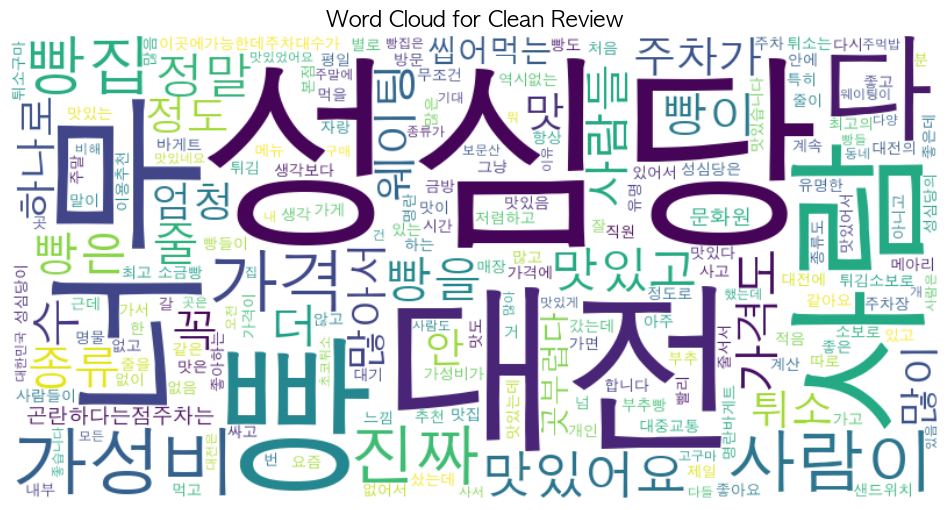

In [77]:
from wordcloud import WordCloud
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter


# 단어 카운트
all_words = ' '.join(newdf['clean_review']).split()
word_counts = Counter(all_words)

# 워드 클라우드 생성
wordcloud = WordCloud(
    font_path='/System/Library/Fonts/Supplemental/AppleGothic.ttf',  # Windows: 'malgun.ttf', macOS: '/System/Library/Fonts/Supplemental/AppleGothic.ttf'
    width=800,
    height=400,
    background_color='white'
).generate_from_frequencies(word_counts)

# 워드 클라우드 시각화
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # 축 제거
plt.title('Word Cloud for Clean Review', fontsize=16)
plt.show()

In [54]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TextClassificationPipeline
import pandas as pd

# 모델과 토크나이저 로드
model_name = "searle-j/kote_for_easygoing_people"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
pipe = TextClassificationPipeline(
    model=model,
    tokenizer=tokenizer,
    device=-1,  # GPU 번호 (-1은 CPU 사용)
    return_all_scores=True,
    function_to_apply='sigmoid'
)

# 감정 라벨
idx_finder = [
    '불평/불만', '환영/호의', '감동/감탄', '지긋지긋', '고마움', '슬픔', '화남/분노', '존경', '기대감', '우쭐댐/무시함', 
    '안타까움/실망', '비장함', '의심/불신', '뿌듯함', '편안/쾌적', '신기함/관심', '아껴주는', '부끄러움', '공포/무서움', 
    '절망', '한심함', '역겨움/징그러움', '짜증', '어이없음', '없음', '패배/자기혐오', '귀찮음', '힘듦/지침', 
    '즐거움/신남', '깨달음', '죄책감', '증오/혐오', '흐뭇함(귀여움/예쁨)', '당황/난처', '경악', '부담/안_내킴', 
    '서러움', '재미없음', '불쌍함/연민', '놀람', '행복', '불안/걱정', '기쁨', '안심/신뢰'
]

# 샘플 데이터프레임 생성 (테스트용)
# 실제 데이터를 사용하려면 newdf를 기존 데이터프레임으로 변경
# newdf = pd.DataFrame({
#     "clean_review": [
#         ["이 영화 정말 좋았어요", "배우 연기도 훌륭했습니다"],
#         ["별로였어요", "다시는 보고 싶지 않아요"],
#         ["정말 재미있고 감동적이었어요"],
#         "영화 자체는 나쁘지 않았지만 조금 지루했어요."
#     ]
# })

# 감정 분석 결과 저장 리스트
senti_list = []

for i in range(len(newdf)):
    # 텍스트 데이터 가져오기
    text_list = newdf.loc[i, "clean_review"]
    
    # 감정 점수 초기화
    senti_dict = [[label, 0] for label in idx_finder]

    # 텍스트 데이터가 리스트인지 확인
    if isinstance(text_list, str):
        text_list = [text_list]  # 문자열은 리스트로 변환

    if isinstance(text_list, list):
        # 텍스트 길이 제한
        text_list = [txt[:511] if len(txt) > 510 else txt for txt in text_list]
        sentence_num = len(text_list)

        # 감정 분석 실행
        results = pipe(text_list)

        # 결과를 senti_dict에 누적
        for sent_scores in results:
            for score_data in sent_scores:
                if score_data["score"] > 0.4:  # 임계값 0.4 이상만 처리
                    finder = idx_finder.index(score_data["label"])
                    senti_dict[finder][1] += score_data["score"]

        # 문장 수로 평균 계산
        emergency = []
        for sent in senti_dict:
            if sent[1] > 0:
                sent[1] /= sentence_num
                emergency.append(sent)

        senti_list.append(emergency)
    else:
        senti_list.append([""])  # 비어 있는 데이터 처리

    print(f"Processed {i + 1}/{len(newdf)} rows")

# 결과를 데이터프레임에 추가
newdf["sentiment"] = senti_list

# 결과를 CSV로 저장
newdf.to_csv("sentimental_analysis.csv", index=False)

# 확인용 출력
print(newdf.head())

/opt/anaconda3/lib/python3.12/site-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Processed 1/1379 rows
Processed 2/1379 rows
Processed 3/1379 rows
Processed 4/1379 rows
Processed 5/1379 rows
Processed 6/1379 rows
Processed 7/1379 rows
Processed 8/1379 rows
Processed 9/1379 rows
Processed 10/1379 rows
Processed 11/1379 rows
Processed 12/1379 rows
Processed 13/1379 rows
Processed 14/1379 rows
Processed 15/1379 rows
Processed 16/1379 rows
Processed 17/1379 rows
Processed 18/1379 rows
Processed 19/1379 rows
Processed 20/1379 rows
Processed 21/1379 rows
Processed 22/1379 rows
Processed 23/1379 rows
Processed 24/1379 rows
Processed 25/1379 rows
Processed 26/1379 rows
Processed 27/1379 rows
Processed 28/1379 rows
Processed 29/1379 rows
Processed 30/1379 rows
Processed 31/1379 rows
Processed 32/1379 rows
Processed 33/1379 rows
Processed 34/1379 rows
Processed 35/1379 rows
Processed 36/1379 rows
Processed 37/1379 rows
Processed 38/1379 rows
Processed 39/1379 rows
Processed 40/1379 rows
Processed 41/1379 rows
Processed 42/1379 rows
Processed 43/1379 rows
Processed 44/1379 ro

In [64]:
import pandas as pd

# CSV 파일 불러오기 (예제에 맞게 경로 변경)
review_df = pd.read_csv("sentimental_analysis.csv")

# sentiment 열에서 가장 큰 점수를 가진 감정만 추출
def get_top_sentiment(sentiments):
    try:
        # 문자열을 리스트로 변환
        sentiments = eval(sentiments)  
        # 가장 큰 점수를 가진 감정을 반환
        if sentiments:
            return max(sentiments, key=lambda x: x[1])
        else:
            return None
    except:
        return None

# 새로운 열에 상위 감정 저장
review_df["top_sentiment"] = review_df["sentiment"].apply(get_top_sentiment)

# top_sentiment에서 라벨과 점수를 분리
review_df["top_sentiment_label"] = review_df["top_sentiment"].apply(lambda x: x[0] if x else None)
review_df["top_sentiment_score"] = review_df["top_sentiment"].apply(lambda x: x[1] if x else None)

# 필요한 컬럼만 서브셋
subset_df = review_df[["clean_review", "top_sentiment_label", "top_sentiment_score"]]

# 결과 확인
print(subset_df)

# 새로운 CSV 저장
subset_df.to_csv("top_sentiments_subset.csv", index=False)

                                           clean_review top_sentiment_label  \
0     대전 용운 국제 수영장 대회 천안 성심당 본점 위치 상황 정오 주차장 주차 네이버 ...              즐거움/신남   
1                    봉지 부띠끄 사람 비닐 주심 센스 메아리 대전 사람 다음 대전              즐거움/신남   
2     대전 여행 알파 오메가 성심당 본점 대전 시내 위치 기차 도보 거리 주차 주차장 주...                 기대감   
3           평일 사람 가게 내부 통로 이동 불편 종류 실패 애플 브리 치즈 샌드위치 기대                 기대감   
4                                대기 예상 메뉴 생각 추천 내부 이곳저곳                 기대감   
...                                                 ...                 ...   
1374                          친절하고 맛있고 가끔대전갈때마다 꼭 들르게 됨                  기쁨   
1375                                              좋은 가게                  기쁨   
1376   속을 채운 빵들부추빵 튀소 크림빵 등이 맛있어요 빵도 많아서 빵돌이 빵순이의 천국입니다                  기쁨   
1377               확실히 대전역점보다 다양하고 깔끔한 느낌가격도 파리바게트보다 싼듯               안심/신뢰   
1378                      제가 이때까지 먹었던 빵중에 가장 맛있는 빵이 파네요                  기쁨   

      top_sentiment_score  
0                0.8412

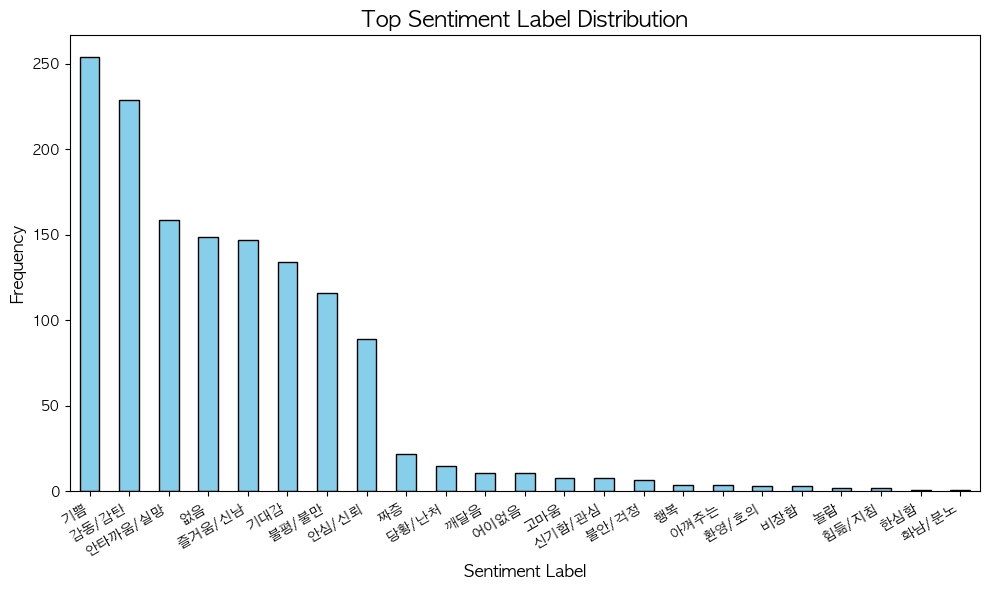

In [65]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import pandas as pd

# 한글 폰트 설정 (예: 맑은 고딕)
# plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows
plt.rcParams['font.family'] = 'AppleGothic'  # macOS
# plt.rcParams['font.family'] = 'NanumGothic'  # Linux (nanum 설치 필요)
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

# 레이블별 빈도 계산
label_counts = subset_df["top_sentiment_label"].value_counts()

# 시각화
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Top Sentiment Label Distribution", fontsize=16)
plt.xlabel("Sentiment Label", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

# X축 레이블 회전
plt.xticks(rotation=30, ha='right', fontsize=10)
plt.tight_layout()
plt.show()

In [74]:
newdf

,clean_review
0,대전 용운 국제 수영장 대회 천안 성심당 본점 위치 상황 정오 주차장 주차 네이버 ...
1,봉지 부띠끄 사람 비닐 주심 센스 메아리 대전 사람 다음 대전
2,대전 여행 알파 오메가 성심당 본점 대전 시내 위치 기차 도보 거리 주차 주차장 주...
3,평일 사람 가게 내부 통로 이동 불편 종류 실패 애플 브리 치즈 샌드위치 기대
4,대기 예상 메뉴 생각 추천 내부 이곳저곳
...,...
1374,친절하고 맛있고 가끔대전갈때마다 꼭 들르게 됨
1375,좋은 가게
1376,속을 채운 빵들부추빵 튀소 크림빵 등이 맛있어요 빵도 많아서 빵돌이 빵순이의 천국입니다
1377,확실히 대전역점보다 다양하고 깔끔한 느낌가격도 파리바게트보다 싼듯
